# $\textbf{Algorithms : IBMQ Practical 3}$

# Implementation of bit-flip error correction and XX stabilizers.

In [86]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import pylatexenc

from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization import plot_state_city
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_bloch_multivector
from qiskit import execute
from qiskit import Aer
from qiskit.quantum_info import Statevector
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account('6b3c87578a7cc9d7d228d9db2d5f8d69c2592b7c46eba8177ea4ebbfaa943562673fa0b36a5c88f97a4abb64151a1258aa72e7f1a56f79f1b2ee8fed346cb495', overwrite=True)
#IBMProvider.save_account('1bc77358790d49740053204e57fa2497f9d021674cdf0e1bb5f91da04af8c33d5b49ee4127707827fed136e13c8738bd16de4b3745f70e3beec963fb281b4edb', overwrite=True)
provider = IBMProvider(instance='ibm-q-education/uni-grenoble-alpe-1/ibmq-quantum-pr')

In [3]:
nairobi = provider.get_backend('ibm_nairobi')

In [4]:
lagos = provider.get_backend('ibm_lagos')

In [5]:
perth = provider.get_backend('ibm_perth')

In [6]:
simulator = AerSimulator()

# Ex1 Measurements of ZZ stabilizers

In [77]:
# function to run on a simulator and get the results
def simulator_sim(circ, simulat, shotes):
    circ_compile = transpile(circ, simulat)
    sim_state = simulator.run(circ_compile, shots=shotes)
    sim_res = sim_state.result()
    sim_counts = sim_res.get_counts()
    
    values = [sim_counts.get(key, 0) for key in ['0',  '1']]
    proba_each_states = []
    
    for value in values:
        proba_each_state = value / shotes
        proba_each_states.append(proba_each_state)
    
    expected_value = proba_each_states[0] - proba_each_states[1]

    return sim_counts, expected_value

Two-Qubit Bell State : $ \ket{\psi} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) $

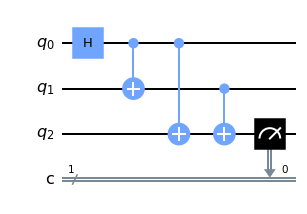

In [8]:
bell_circ = QuantumCircuit(3,1)
bell_circ.h(0)
bell_circ.cx(0,1)
bell_circ.cx(0,2)
bell_circ.cx(1,2) 
bell_circ.measure(2,0)
bell_circ.draw('mpl')

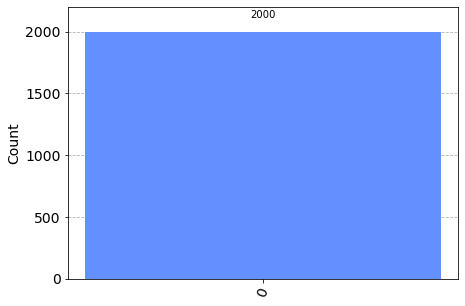

In [9]:
circ_compile = transpile(bell_circ, simulator)
sim_state = simulator.run(circ_compile, shots=2000)
sim_res = sim_state.result()
sim_counts = sim_res.get_counts()
plot_histogram(sim_counts)

In [78]:
z1z2_counts, exp_z1z2 = simulator_sim(bell_circ, simulator, 2000)
print(exp_z1z2)

1.0


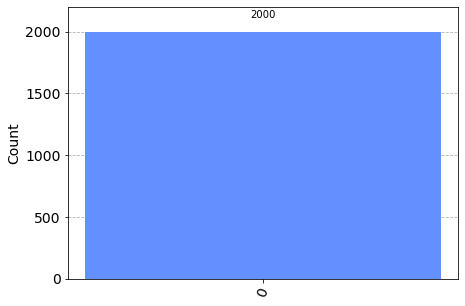

In [79]:
plot_histogram(z1z2_counts)

Two-Qubit Bell State : $ \ket{\psi} = \frac{1}{\sqrt{2}} (\ket{01} + \ket{10}) $

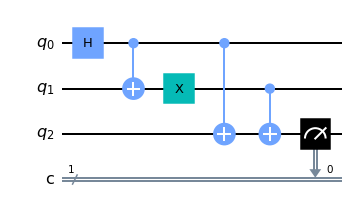

In [12]:
bell_circ1 = QuantumCircuit(3,1)
bell_circ1.h(0)
bell_circ1.cx(0,1)
bell_circ1.x(1)
bell_circ1.cx(0,2)
bell_circ1.cx(1,2)
bell_circ1.measure(2,0)
bell_circ1.draw('mpl')

In [80]:
counts, exp_z1z2_circ2 = simulator_sim(bell_circ1, simulator, 2000)

-1.0


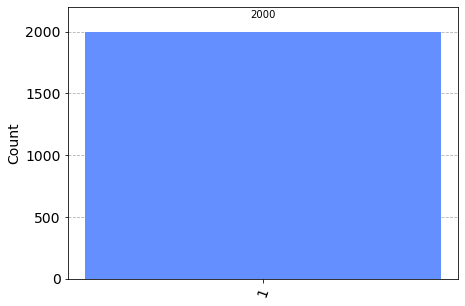

In [81]:
print(exp_z1z2_circ2)
plot_histogram(counts)

In [15]:
circ_list = [bell_circ, bell_circ1]

In [14]:
job_ex1 = execute(circ_list, nairobi, shots=2000)

In [16]:
circ_ex1_ibm = provider.backend.retrieve_job('cmpjpxbb9x9g0088swp0')
ibm_results_ex1 = circ_ex1_ibm.result()
ibm_counts_ex1 = ibm_results_ex1.get_counts()

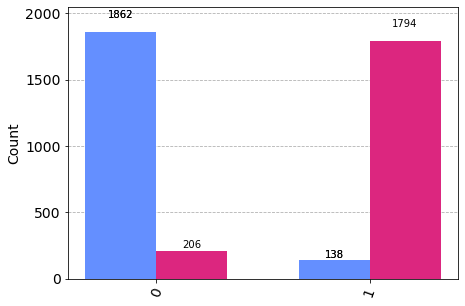

In [75]:
# Ibm results for the first circiut
plot_histogram(ibm_counts_ex1)

The logical bit are :
\begin{equation}
\ket{0_L} = \ket{000};
\ket{1_L} = \ket{111}\\
\end{equation}


Now the syndrome measurement may be performed by measuring the observalbes $Z_1 Z_2$
Thus, we get :

\begin{equation}
Z_1 Z_2 = \left\{{+1 \text{ for states like } \ket{0}\ket{0}\otimes (.) or \ket{1}\ket{1}\otimes (.)\atop -1 \text{for states like} \ket{0}\ket{1}\otimes (.) or \ket{1}\ket{0}\otimes (.)} \right.
\end{equation}

Now we build our circuit, with 3 qubits, by applying an Hadamard gate on the first qubit and CNOT gate between the first and the second qubit for the encoding then we make a error-dectection  thanks to the ancilla, to finish with the dectection of the state producted which give us the expected value $Z_1 Z_2$.

After the circuit finished, we can compute it on a simulator and an IBM to observe and compare their outcomes.
Before the ancila qubit the state is $ \ket{\psi} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) $ . After applying of ancilla which wont flip our state, we get the result in the simulator of the 100% probability of the state $\ket{0}$ then we have the expected value $Z_1 Z_2 = 1$. 


For the other circit that we test is (bell_circ2) the state in this circiut is $ \ket{\psi} = \frac{1}{\sqrt{2}} (\ket{01} + \ket{10}) $  as we know the ancilla qubit will flip to $\ket{1}$ and the expectation value is $Z_1 Z_2 = -1$ as expected


Now the difference between IBM and simulator comes from the fact that we cannot get a perfect CNOT gate in the ancilla, we have some errors on theses gates which occurs some fluctuations in the final result; indeed, unlike the simulator, where we have only one state due to the fact we have solely perfect gates operators, the IBM give us another state with a tiny probability.

# Ex 2 The 3-qubits bit flip code on the simulator

In [63]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

basis_gates = ['u1','u2','u3','cx']

def get_noise(p):
    bit_flip = pauli_error([('X', p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(bit_flip,['u1'])
    noise_model.add_all_qubit_quantum_error(bit_flip,['u2'])
    noise_model.add_all_qubit_quantum_error(bit_flip,['u3'])
    return noise_model

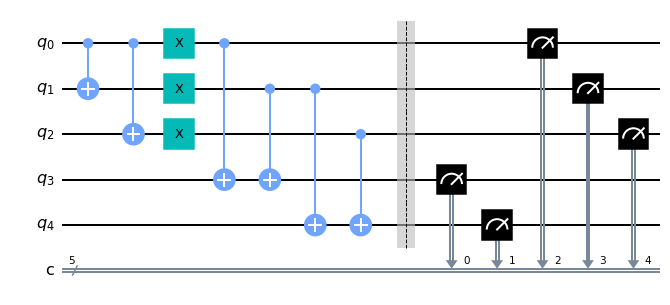

In [55]:
logic_circ = QuantumCircuit(5,5)
logic_circ.cx(0,1)
logic_circ.cx(0,2)
logic_circ.x(0)
logic_circ.x(1)
logic_circ.x(2)
logic_circ.cx(0,3)
logic_circ.cx(1,3)
logic_circ.cx(1,4)
logic_circ.cx(2,4)
logic_circ.barrier()
logic_circ.measure(3,0)
logic_circ.measure(4,1)
logic_circ.measure(0,2)
logic_circ.measure(1,3)
logic_circ.measure(2,4)
logic_circ.draw('mpl')

In [56]:
# function to calculate the logical error.
def logic_error_cal(circ, simulator, noise, shots, basis_gates):
    result = execute(circ, backend=simulator, noise_model=noise,shots=shots,basis_gates=basis_gates).result()
    sim_counts = result.get_counts()
    
    values = [sim_counts.get(key, 0) for key in ['00000', '00101','01011','10010']]
    proba_each_states = []
    
    for value in values:
        proba_each_state = value / shots
        proba_each_states.append(proba_each_state)
    mean_proba_value = (proba_each_states[0]+proba_each_states[1]+proba_each_states[2]+proba_each_states[3])/4
    return sim_counts , mean_proba_value

({'01011': 237, '00000': 135, '10111': 573, '11001': 593, '10010': 254, '01110': 583, '00101': 261, '11100': 1364}, 0.0554375)


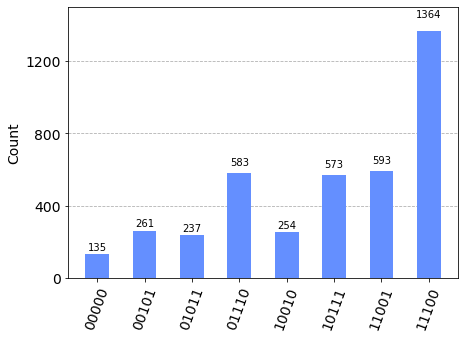

In [90]:
noise_model = get_noise(0.3)
error_cal = logic_error_cal(logic_circ, simulator, noise_model, 4000, basis_gates)
print(error_cal)
plot_histogram(error_cal[0])

as we see depending on the value of the <Z_1 Z_2> and <Z_2 Z_3> we can detect the error. But some times if we have two bit flip or three bit flip the expectation values of  <Z_1 Z_2> and <Z_2 Z_3> have the same outcome for one bit flip thats why its not always true. For example as we see from above if we see the states 01110 and 10010, the first state has the second and the thrid bit flip, also the other state has the first bitflip but both states show the same value for the expectation value.

# Different values of P

In [46]:
P = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1]

In [47]:
P_l = []

for i in P:
    noise_model2 = get_noise(i)
    pl_calc = logic_error_cal(logic_circ, simulator, noise_model2, 4000, basis_gates)
    P_l.append(pl_calc[1])    

In [48]:
print(P_l)

[0.0, 0.008, 0.026375000000000003, 0.05525, 0.0899375, 0.12525, 0.159375, 0.19518749999999999, 0.22431250000000003, 0.24318749999999997, 0.25]


In [67]:
linear = []
for i in P:
    linear.append(0.25*i)

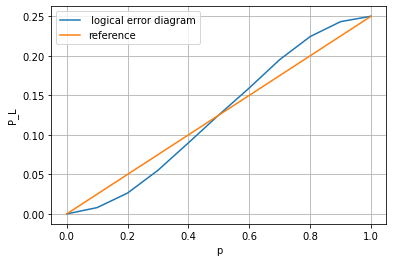

In [73]:
plt.plot(P, P_l, label=' logical error diagram')
plt.plot(P, linear, label= 'reference')
plt.xlabel('p')
plt.ylabel('P_L')
plt.grid(True)
plt.legend()
plt.show()

To sumarize we need the lifte time of the logic qubit which is greater than the physical qubit i.e P_L< P for quantum error correction to be useful

# Optinal exersice Measurements of XX stabilizers

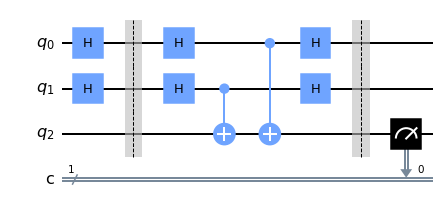

In [22]:
bell_circ_1 = QuantumCircuit(3,1)
bell_circ_1.h(0)
bell_circ_1.h(1)
bell_circ_1.barrier()
bell_circ_1.h(0)
bell_circ_1.h(1)
bell_circ_1.cx(1,2)
bell_circ_1.cx(0,2)
bell_circ_1.h(0)
bell_circ_1.h(1)
bell_circ_1.barrier()
bell_circ_1.measure(2,0)
bell_circ_1.draw('mpl')

In [29]:
xx_counts1, exp_x1x2_circ1 = simulator_sim(bell_circ_1, simulator, 2000)

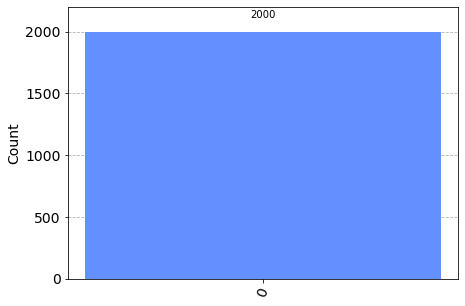

In [30]:
plot_histogram(xx_counts1)

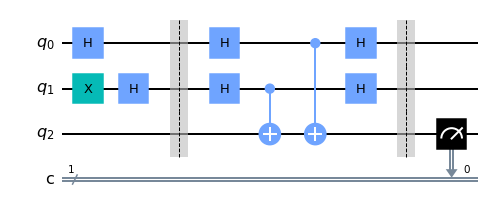

In [40]:
bell_circ2 = QuantumCircuit(3,1)
bell_circ2.h(0)
bell_circ2.x(1)
bell_circ2.h(1)
bell_circ2.barrier()
bell_circ2.h(0)
bell_circ2.h(1)
bell_circ2.cx(1,2)
bell_circ2.cx(0,2)
bell_circ2.h(0)
bell_circ2.h(1)
bell_circ2.barrier()
bell_circ2.measure(2,0)
bell_circ2.draw('mpl')

In [31]:
xx_counts2, exp_x1x2_circ2 = simulator_sim(bell_circ2, simulator, 2000)

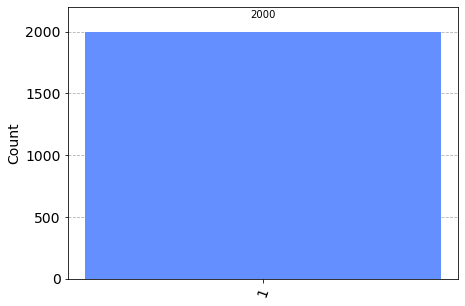

In [32]:
plot_histogram(xx_counts2)

In [34]:
circ_list_1 = [bell_circ_1, bell_circ2]

In [ ]:
"""
job ID : 
nairobi : cmz4fpp3r3vg008wf76g
perth : cmpk5p6b9x9g0088sx2g / cmz4fjprmwhg008bst6g
lagos : cmz4fzqrmwhg008bst70
"""

job_ex1 = execute(circ_list, lagos, shots=2000)

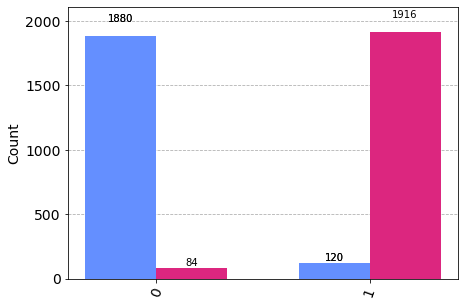

In [87]:
phase_flip_job_ibm = provider.backend.retrieve_job('cmz4fzqrmwhg008bst70')

phase_flip_result_ibm = phase_flip_job_ibm.result()
phase_flip_counts_ibm = phase_flip_result_ibm.get_counts()
plot_histogram(phase_flip_counts_ibm)

The logical bit are :
\begin{equation}
\ket{0_L} = \ket{+++};
\ket{1_L} = \ket{---}\\
\end{equation}
with respectively in qubit basis

\begin{equation}
\ket{+} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1});
\ket{-} = \frac{1}{\sqrt{2}}(\ket{0} - \ket{1})
\end{equation}

This changing of basis is made thanks to the Hadamard gate, then we just applied it in our circuit in exercise 1.
Now the syndrome measurement may be performed by measuring the observalbes $X_1 X_2 = H Z_1 Z_2 H$ (thanks to HXH=Z) similarly to the measurement of $Z_1 Z_2$ for the bit flip code in exercise 1.
Thus, we get :

\begin{equation}
X_1 X_2 = \left\{{+1 \text{ for states like } \ket{+}\ket{+}\otimes (.) or \ket{-}\ket{-}\otimes (.)\atop -1 \text{for states like} \ket{+}\ket{-}\otimes (.) or \ket{-}\ket{+}\otimes (.)} \right.
\end{equation}

Now we build our circuit, with 3 qubits, by applying an Hadamard gate on the 2 first qubit for the encoding then we make a error-dectection  thanks to the ancilla, similary in the first exercise; to finish with the dectection of the state producted which give us the expected value $X_1 X_2$.

After the circuit finished, we can compute it on a simulator and an IBM to observe and compare their outcomes.
For the first circuit (see bell_circ), we apply 2 hadamards gate on the qubit in groundstate, then 2 additionnal Hadamard gate for the error-dectection, we just recover our initial state $\ket{00}$. After applying of ancilla which wont flip our state, we get the result in the simulator of the 100% probability of the state $\ket{0}$ then we have the expected value $X_1 X_2 = 1$. 


From now on we can ourselves what will happen when we apply initially an X gate on the second qubit to flip the state(see bell_circ1). We start with initial state in ground state, then we build a "random" state by applying hadamard gate which occurs the state $\ket{10}$ before ancilla. The ancilla will flip our state like following : the first CNOT which control the second qubit "0" and target the state $\ket{0}$ give the state $\ket{10}$ and then the second CNOT which control the first qubit "1" and target 0 will flip the state in $\ket{1}$ which is what the simulator give us with the 100% of probability, thus we get $X_1 X_2 = -1$ as expected from the previous result.


Now the difference between IBM and simulator comes from the fact that we cannot get a perfect CNOT gate in the ancilla, we have some errors on theses gates which occurs some fluctuations in the final result; indeed, unlike the simulator, where we have only one state due to the fact we have solely perfect gates operators, the IBM give us another state with a tiny probability.